In [1]:
import random, numpy as np
import torch, torch.nn as nn, torch.optim as optim
import torchvision.transforms as xforms, torchvision.datasets, torchvision.utils
import matplotlib.pyplot as plt, matplotlib.animation as animation
import PIL
import pdb
import itertools
import pathlib
import IPython.display
from torchvision import datasets, models, transforms
from torchvision.models.resnet import BasicBlock
from tqdm.auto import tqdm
from PIL import Image

Make folders for the dataset and copy 2 images 500 times for testing

In [2]:
!mkdir dataset
!mkdir dataset/A
!mkdir dataset/B

In [3]:
! for i in {1..500}; do cp city.png "dataset/A/city$i.jpg" ; done
! for i in {1..500}; do cp picasso.png "dataset/B/picasso$i.jpg" ; done

Dataset (taken from https://github.com/eriklindernoren/PyTorch-GAN)

In [2]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms_, unaligned=False):
        root_dir = pathlib.Path(root_dir).resolve()
        self.transform = transforms_
        self.unaligned = unaligned
        self.files_A = sorted(root_dir.glob('A/*.jpg'))
        self.files_B = sorted(root_dir.glob('B/*.jpg'))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

Testing the dataset:

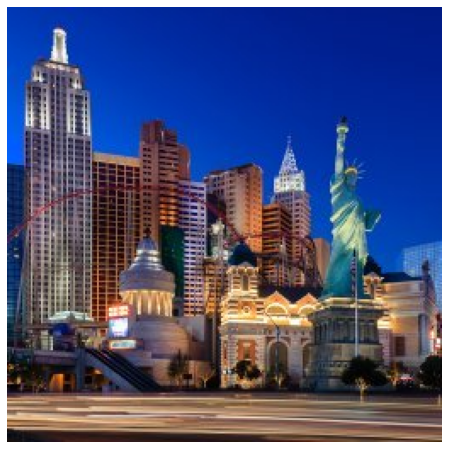

In [7]:
xform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = ImageDataset("dataset", transforms_=xform)
dataset[0]
plt.figure(figsize=(16,8)); plt.axis('off')
plt.imshow(dataset[0]['B'].permute(1,2,0))
plt.imshow(dataset[0]['A'].permute(1,2,0))

The critic: (taken from lecture)

Todo: fix critic so that it works on image sizes other than 64

In [3]:
class Critic(nn.Module):
    def __init__(self, feat_dim=64):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, feat_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat_dim, feat_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat_dim * 2, feat_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat_dim * 4, feat_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feat_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
        def init_layer(layer):
            if layer.__class__.__name__[:4] == 'Conv':
                nn.init.normal_(layer.weight, 0.0, 0.02)
            elif layer.__class__.__name__[:9] == 'BatchNorm':
                nn.init.normal_(layer.weight, 1.0, 0.02)
                nn.init.constant_(layer.bias, 0.0)

        self.layers.apply(init_layer)

        
    def forward(self, input):
        return self.layers(input)

The generator: (modified from lecture)

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        vgg = torchvision.models.vgg11(pretrained=True)
        # freezing all vgg layers
        for param in vgg.parameters():
            param.requires_grad = False
        # the three convolution layers pre-trained from vgg11
        self.conv_layers = nn.Sequential(
            vgg.features[0],
            vgg.features[1],
            nn.InstanceNorm2d(64),
            vgg.features[3],
            vgg.features[4],
            nn.InstanceNorm2d(128),
            vgg.features[6],
            vgg.features[7],
            nn.InstanceNorm2d(256)
        )

        # 9 resnet blocks
        self.resnet_layers = nn.Sequential(
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
            BasicBlock(256, 256),
        )

        # the 3 transposed convolution layers
        self.tconv_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, 1, 1, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, 3, 1, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Sigmoid()
        )

        def init_layer(layer):
            if layer.__class__.__name__[:4] == 'Conv':
                nn.init.normal_(layer.weight, 0.0, 0.02)
            elif layer.__class__.__name__[:9] == 'BatchNorm':
                nn.init.normal_(layer.weight, 1.0, 0.02)
                nn.init.constant_(layer.bias, 0.0)

        self.tconv_layers.apply(init_layer)

        
    def forward(self, samples):
        # pass sample through all the layers
        #pdb.set_trace()
        out = self.conv_layers(samples)
        out = self.resnet_layers(out)
        out = self.tconv_layers(out)
        return out

Testing generator with input of an image of a city. We can see some of the outlines of the buildings

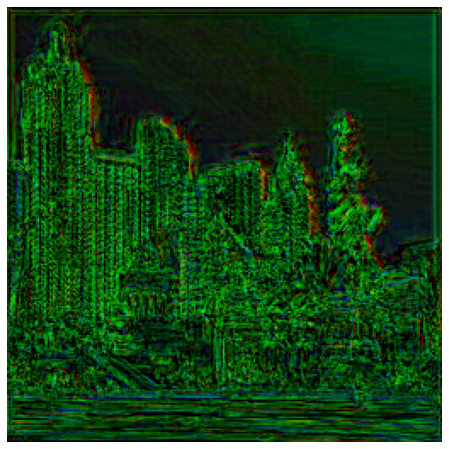

In [99]:
gen = Generator()
gen.eval()
img = Image.open("city.jpg")
xform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
img = xform(img)
fake_samples = gen(img.unsqueeze(0))
plt.figure(figsize=(16,8)); plt.axis('off')
plt.imshow(torchvision.utils.make_grid(fake_samples.detach().cpu(), normalize=True).permute(1,2,0))

Training code: (taken from lecture and https://github.com/eriklindernoren/PyTorch-GAN)

In [10]:
def run_train(model_genA, model_genB, model_critA, model_critB, ds, criterion_cycle, criterion_gen, opt_gen, opt_critA, opt_critB, scheduler_gen, scheduler_critA, scheduler_critB, dev, n_epochs=10, batch_sz=32, ref=None):
    model_genA = model_genA.to(dev)
    model_genB = model_genB.to(dev)
    model_critA = model_critA.to(dev)
    model_critB = model_critB.to(dev)
    model_genA.train()
    model_genB.train()
    model_critA.train()
    model_critB.train()
    ldr = torch.utils.data.DataLoader(ds, batch_size=batch_sz)

    tq_epochs = tqdm(range(n_epochs), desc='epochs', unit='ep')
    for epoch_no, epoch in enumerate(tq_epochs):
        tq_iters = tqdm(ldr, desc='iter')
        for samples in tq_iters:
            real_A = samples['A'].to(dev)
            real_B = samples['B'].to(dev)

            # labels for real and fake images for the critics
            valid = torch.full((batch_sz,), 1, dtype=torch.float, device=dev)
            fake = torch.full((batch_sz,), 0, dtype=torch.float, device=dev)

            # ------------------
            #  Train Generators
            # ------------------
            opt_gen.zero_grad()

            # Generator loss against the critics
            fake_B = model_genA(real_A)
            loss_GAN_AB = criterion_gen(model_critB(fake_B).squeeze(), valid)
            fake_A = model_genB(real_B)
            loss_GAN_BA = criterion_gen(model_critA(fake_A).squeeze(), valid)
            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

            # Cycle loss between the starting and ending image
            recov_A = model_genB(fake_B)
            loss_cycle_A = criterion_cycle(recov_A, real_A)
            recov_B = model_genA(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

            # Total loss
            loss_G = loss_GAN + 10 * loss_cycle

            # back-propogate
            loss_G.backward()
            opt_gen.step()

            # -----------------------
            #  Train Discriminator A
            # -----------------------

            opt_critA.zero_grad()

            # Real loss
            loss_real = criterion_gen(model_critA(real_A).squeeze(), valid)
            # Fake loss (on batch of previously generated samples)
            loss_fake = criterion_gen(model_critA(fake_A.detach()).squeeze(), fake)
            # Total loss
            loss_D_A = (loss_real + loss_fake) / 2

            loss_D_A.backward()
            opt_critA.step()

            # -----------------------
            #  Train Discriminator B
            # -----------------------

            opt_critB.zero_grad()

            # Real loss
            loss_real = criterion_gen(model_critB(real_B).squeeze(), valid)
            # Fake loss (on batch of previously generated samples)
            loss_fake = criterion_gen(model_critB(fake_B.detach()).squeeze(), fake)
            # Total loss
            loss_D_B = (loss_real + loss_fake) / 2

            loss_D_B.backward()
            opt_critB.step()

            loss_D = (loss_D_A + loss_D_B) / 2

        scheduler_gen.step()
        scheduler_critA.step()
        scheduler_critB.step()
        tq_epochs.write(f'critics loss {loss_D:.3f} / generators loss {loss_G:.3f}')
        if ref is not None:
            ref_A, ref_imgs = ref
            ref_fakes = model_genA(ref_A.unsqueeze(0)).detach().cpu()
            ref_imgs.append(torchvision.utils.make_grid(ref_fakes, normalize=True))

Testing only 1 generator and 1 critic with some data

In [11]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)), torchvision.transforms.ToTensor()])
dataset = ImageDataset('dataset', xform)
len(dataset)

500

In [12]:
device = torch.device('cuda:0')
#device = torch.device('cpu')


ref_fake_imgs = []
ref_A = dataset[0]['A'].to(device)

model_genA = Generator()
model_genB = Generator()
model_critA = Critic(feat_dim=64)
model_critB = Critic(feat_dim=64)
criterion_cycle = nn.L1Loss()   # loss between the starting image and the same image passed through the two generators
criterion_gen = nn.BCELoss()    # loss for the generators when evaluated with the critic

opt_gen = torch.optim.Adam(
    itertools.chain(model_genA.parameters(), model_genB.parameters()), lr=1e-4
)
opt_critA = torch.optim.Adam(model_critA.parameters(), lr=1e-4)
opt_critB = torch.optim.Adam(model_critB.parameters(), lr=1e-4)

lr_scheduler_gen = torch.optim.lr_scheduler.StepLR(opt_gen, step_size=3, gamma=0.1)
lr_scheduler_critA = torch.optim.lr_scheduler.StepLR(opt_critA, step_size=3, gamma=0.1)
lr_scheduler_critB = torch.optim.lr_scheduler.StepLR(opt_critB, step_size=3, gamma=0.1)

In [14]:
model_genA

The training code runs: (running on just the same images copied 500 times, so the critic loss will be 0)

In [20]:
run_train(model_genA, model_genB, model_critA, model_critB, dataset, criterion_cycle, criterion_gen, opt_gen, opt_critA, opt_critB, lr_scheduler_gen, lr_scheduler_critA, lr_scheduler_critB, device, n_epochs=10, batch_sz=4, ref=(ref_A,ref_fake_imgs))


critics loss 0.000 / generators loss 11.020



critics loss 0.000 / generators loss 11.195



critics loss 0.000 / generators loss 11.350



critics loss 0.000 / generators loss 11.332



critics loss 0.000 / generators loss 11.339



critics loss 0.000 / generators loss 11.355



critics loss 0.000 / generators loss 11.352



critics loss 0.000 / generators loss 11.352



critics loss 0.000 / generators loss 11.352



critics loss 0.000 / generators loss 11.352



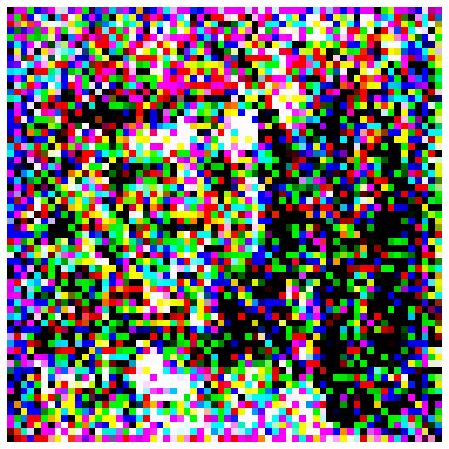

In [21]:
fig = plt.figure(figsize=(16,8)); plt.axis('off')
frames = [[plt.imshow(img.permute(1,2,0), animated=True)] for img in ref_fake_imgs]
anim = animation.ArtistAnimation(fig, frames, interval=1000, repeat_delay=1000, blit=True)
IPython.display.HTML(anim.to_jshtml())